### **Problem :**

Prediction of type 2 diabetes mellitus (T2DM) at an early stage can lead to improved treatment and increased quality of life. Diagnosis of diabetes is considered a challenging problem at an early stage. A single parameter is not very effective to accurately diagnose diabetes and may be misleading in the decision making process. There is a need to combine different parameters to effectively predict diabetes at an early stage. You need to develop a machine learning model that can predict whether people have diabetes based on a subset of their clinical data.


Read more:

https://www.nature.com/articles/s41598-020-61123-x

https://www.sciencedirect.com/science/article/pii/S2352914819300176 (dataset description)



### **Dataset :**

The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases (NIH). The target variable is specified as "Outcome"; 1 indicates positive diabetes test result, 0 indicates negative.

### **Variables :**
* Pregnancies    : Number of pregnancies
* Glucose        : 2-hour plasma glucose concentration in the oral glucose tolerance test
* Blood Pressure : Blood Pressure (Smallness) (mm Hg)
* SkinThickness  : Skin Thickness
* Insulin        : 2-hour serum insulin (mu U/ml)
* Diabetes Pedigree Function : Function (2 hour plasma glucose concentration in oral glucose tolerance test)
* BMI            : Body mass index
* Age            : Age (years)
* Outcome        : Have the disease(1) or not (0)

###📚 0. Import Libraries (Nothing to do)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [5]:
# some adjustments
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

### 📚1. Reading the Dataset (Nothing to do)

You can alternatively use colab's [import file feature](https://colab.research.google.com/notebooks/io.ipynb)

In [6]:
# from google.colab import files
# uploaded = files.upload()

df_ = pd.read_csv('diabetes.csv')
df = df_.copy()

## 💿 2. Data preparation

## 🧾 Initial Exploration
❗Check the dataset info and look for potential issues. How many numerical values are there? How many categorical values? Hint: use the pandas dataframe [describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) or [info](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) functions.

In [7]:
## .. add your code here ..
# data overview (data types, non-null counts, null counts)
display(df.describe(include='all').T)

df_info = pd.DataFrame(df.dtypes, columns=['Data Type'])
df_info['Non-Null Count'] = df.notnull().sum()
df_info['Null Count'] = df.isnull().sum()
df_info.sort_values('Null Count', ascending=False, inplace=True)
df_info.style.set_table_attributes('class="table table-striped"').format({'Null Percentage': '{:.2f}%'})

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


,Data Type,Non-Null Count,Null Count
Pregnancies,int64,768,0
Glucose,int64,768,0
BloodPressure,int64,768,0
SkinThickness,int64,768,0
Insulin,int64,768,0
BMI,float64,768,0
DiabetesPedigreeFunction,float64,768,0
Age,int64,768,0
Outcome,int64,768,0


###2.1 Data exploration

❗**Plot the label distribution. What is the ratio of positive cases?**
(Hint: use the function cat_summary which uses seaborns  countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html

Alternatively you can use the histplot method directly: https://seaborn.pydata.org/generated/seaborn.histplot.html.

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


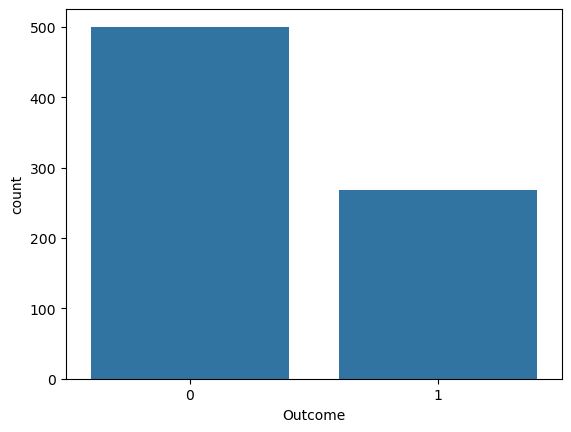

In [8]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


## ... plot here ... ##
cat_summary(df, "Outcome", plot=True)

❗**Summarize the features. Plot the distribution of each feature. Do you notice anything weird?**

(Hint: use the histplot seaborn method: https://seaborn.pydata.org/generated/seaborn.histplot.html)

Tryout the pairplot method from seaborn also!

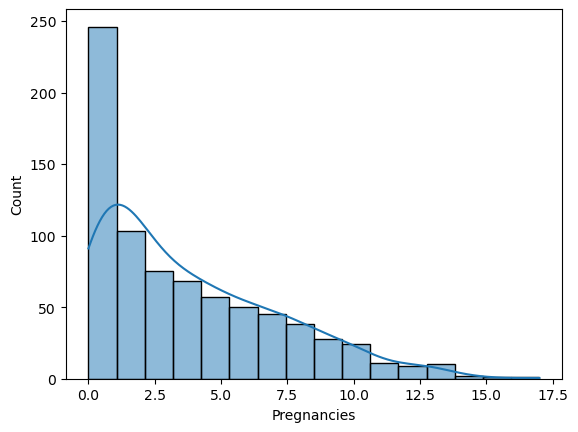

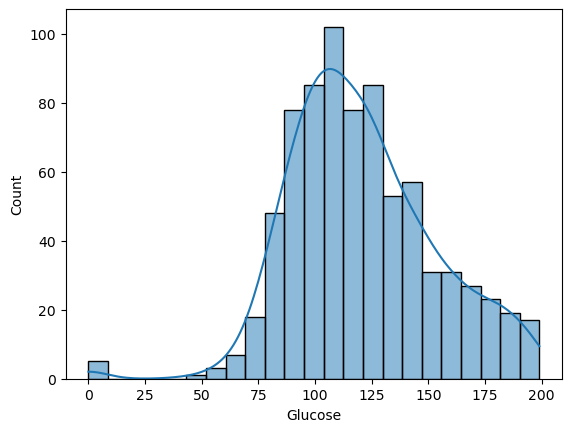

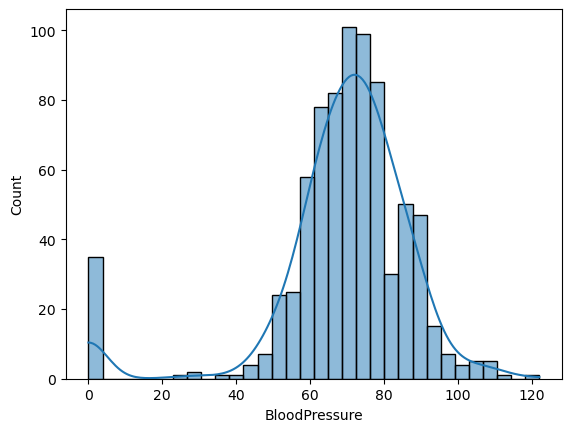

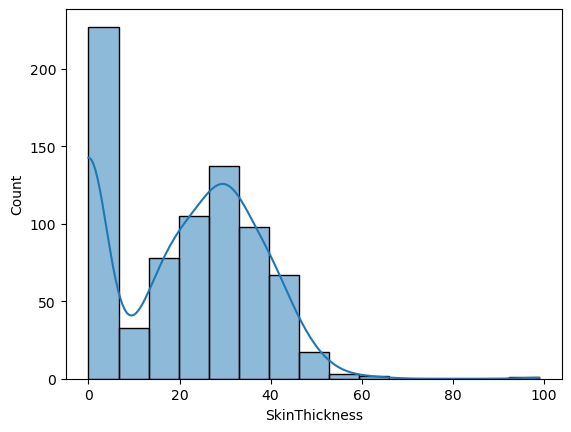

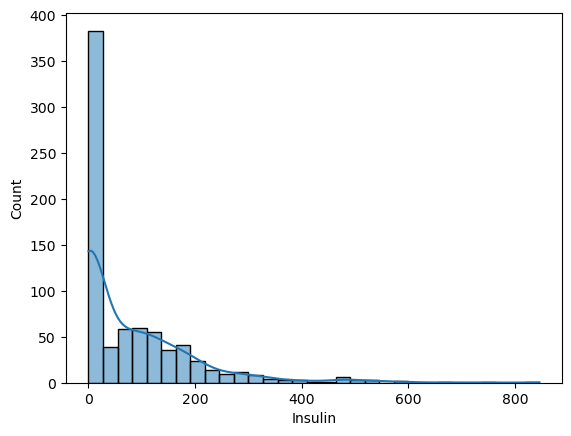

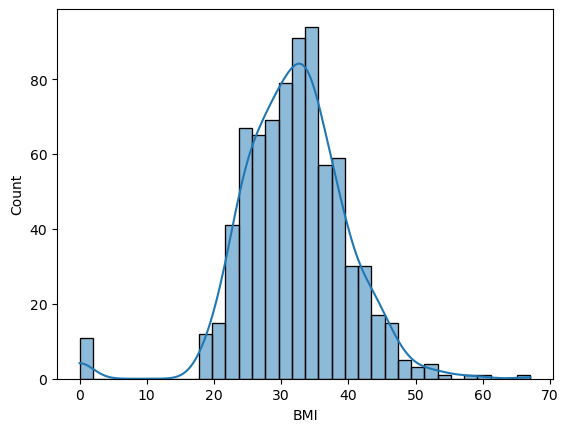

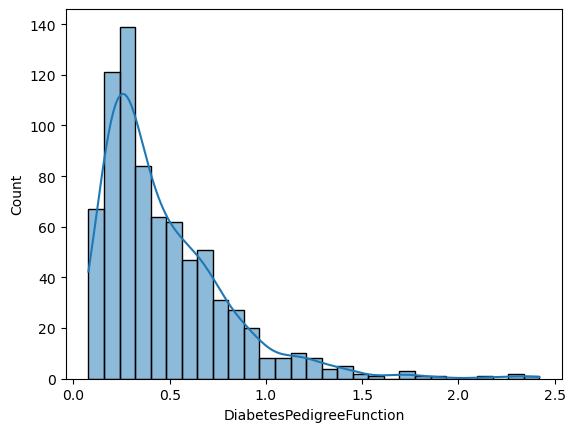

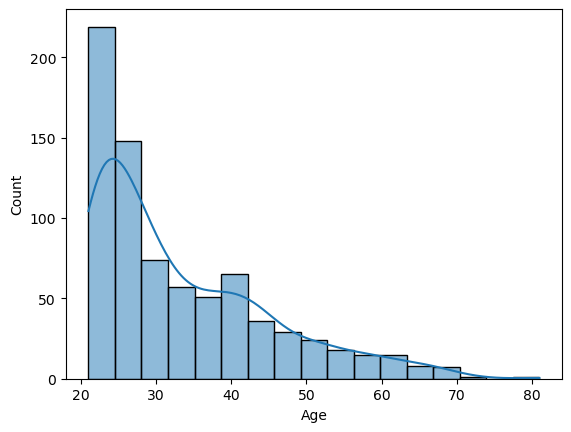

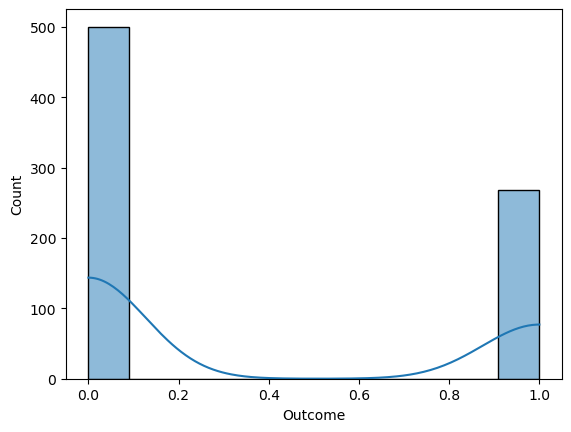

In [9]:
def num_summary(dataframe, numerical_col, plot= False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

## ... plot here ... ##
# to use code above then use this code below:
# for col in df.columns:
#     if df[col].dtypes != 'O':
#         num_summary(df, col, plot=True)

# to use histplot directly:
for col in df.columns:
    sns.histplot(data=df, x=col, kde=True)
    plt.show()

❗**Are patients diagnosed with diabetes older or younger than the rest?** (You can use the function below. Or you  write your own script directly)

In [10]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

## ....add line here ##
target_summary_with_num(df, "Outcome", "Age")

           Age
Outcome       
0       31.190
1       37.067




❗**Plot the correlation matrix between different features (Outcome included). Which feature is highest correlated with the target?** (Hint: Use the correlation function in the dataframe type. You can plot it using seaborn heatmap)

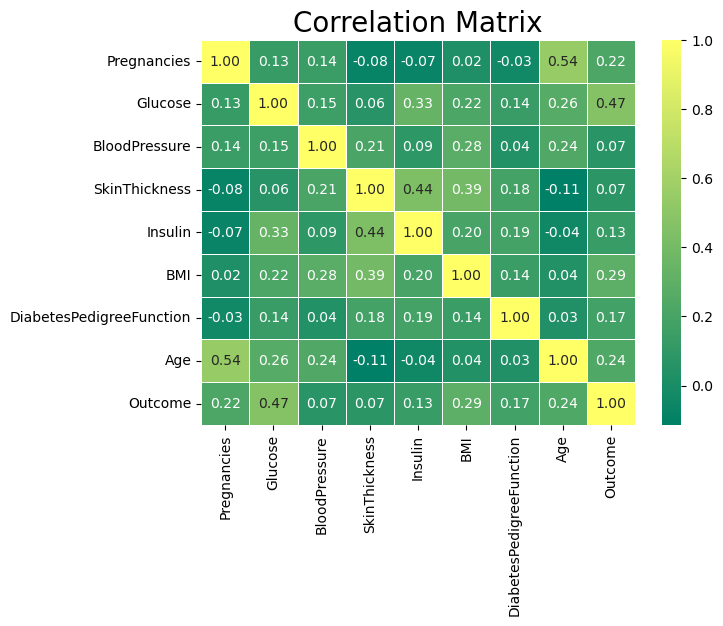

In [11]:
f, ax = plt.subplots(figsize=[7, 5])
## ... add code here ##
ax.set_title("Correlation Matrix", fontsize=20)
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="summer", cbar=True, linewidths=0.5)
plt.show()

### 🔎 2.2 Missing Value Analysis

❗**How many missing values (NA values) are there?** Hint: https://pandas.pydata.org/docs/user_guide/missing_data.html



In [12]:
## .. add code here ...
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

However, if you look at BLOODPRESSURE (or BMI or INSULIN for example) you can notice some values which do not make any sense.  

In [13]:
## .. replace "??" by the nonsensical value .. ""
# df['BloodPressure'].head(100) # some values are 0 which is not possible for blood pressure
(df['BloodPressure']== 0).sum()

np.int64(35)

❗**Replace the values with NaN** _Hint_: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html (use np.nan)

In [14]:
(df['Glucose']== 0).sum()

np.int64(5)

In [15]:
(df['Insulin']== 0).sum()

np.int64(374)

In [16]:
(df['SkinThickness']== 0).sum()

np.int64(227)

In [17]:
(df['BMI']== 0).sum()

np.int64(11)

In [18]:
na_cols = df.isna().sum()
print(na_cols) 

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [19]:
df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]]= df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].replace(0, np.nan)

In [20]:
na_cols = df.isna().sum()
print(na_cols)  

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


❗**How would you handle missing data?** Hint: you can use the function bellow.
Alternatively, use the fillna method: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html.

Some examples:
https://towardsdatascience.com/8-methods-for-handling-missing-values-with-python-pandas-842544cdf891




In [21]:
# def median_target(variable):
#     temp = df[df[variable].notna()]
#     temp = temp[[variable, 'Outcome']].groupby(['Outcome'])[[variable]].median().reset_index()
#     # print("temp:", temp)
#     return temp

# my code: 
# loop through each column and fill missing values
for col in ['BMI', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin']:
    # print(f"Processing column: {col}")
    # print(f"Missing values before: {df[col].isna().sum()}")
    # print("med:", df[col].median())
    df[col] = df[col].fillna(df[col].median())

In [22]:
na_cols = df.isna().sum()
print(na_cols)  # should be zero now

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [23]:
# columns = df.columns
# columns = columns.drop("Outcome")

# for col in columns:
#     df.loc[(df['Outcome'] == 0) & (df[col].isna()), col] = ## add code here
#     df.loc[(df['Outcome'] == 1) & (df[col].isna()), col] = ## add code here


# ## or just add your own code ## ## i did this above already ##

## 🤖 3. Model training and evalation

Train/test split

In [24]:
# note we should have done this first so the stats we do on the train set dont leak into the test set 
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

### 3.0 Feature Standarzation

❗**Why do we need feature standardization?** (Hint: to implement use a Scaler object from python)

In [25]:
# Standardization for numerical cols
rs = StandardScaler() ## ... choose a scaler ##
X_train= rs.fit_transform(X_train)

# Standardize the test data based on the scaler fit on the train data
X_test= rs.transform(X_test)


###3.1 Simple model

❗**Train a ML model!** Data is already split into train and test. First, try out a [logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). What accuracy do you get?      

In [26]:
from sklearn.linear_model import LogisticRegression

## ...import your linear classifier ##
model = LogisticRegression()
## ...train your model ##
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7662337662337663

###3.2 Evaluation metrics

❗**Plot the results. What other metrics than accuracy can you think of?** Hint: [ROC](https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python). What about precision-recall? Confusion m...?

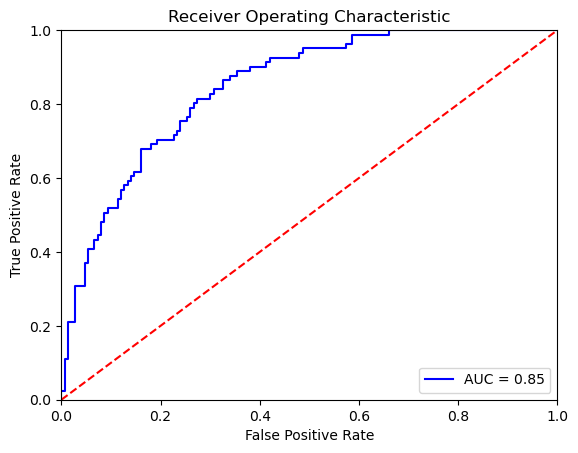

Confusion Matrix : 
 [[132  18]
 [ 36  45]]


In [ ]:
"""
A Receiver Operating Characteristic (ROC) curve is a graph that shows the performance of a binary classification model at different thresholds, 
plotting the True Positive Rate (TPR) against the False Positive Rate (FPR)
"""
import sklearn.metrics as metrics
## Calculate the fpr and tpr for all thresholds of the classification ##
probs = model.predict_proba(X_test)
y_pred_proba = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

## ... plot a roc curve ##
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## ... plot another curve? ##


## Get the confusion matrix ##
from sklearn.metrics import confusion_matrix 
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix : \n', cm)


###3.3 Compare different types of classifiers

❗Try an SVM or a Random Forest. Hint: Check out the [sklearn](https://scikit-learn.org/stable/supervised_learning.html) classifiers.

In [38]:
from sklearn.svm import SVC

# split data
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

# train SVM 
model = SVC(probability=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {acc:.4f}")

SVM Accuracy: 0.7446


**Robust evaluation**

❗Evaluate your model's performance on multiple train-test splits. What is the average performance of your model? Try out different metrics.  

Hint: [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html). You can either implement it on your own (for loop) or use the functions available in sklearn.

In [41]:
#cross validation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import svm

# define model 
clf = svm.SVC(kernel='linear', C=1, random_state=42)


# method 1: simple k fold with folds 
scores = cross_val_score(clf, X, y, cv=5)
print("5-Fold CV Scores:", scores)
print("Mean Accuracy:", scores.mean())


# method 2: shiffle split, 5 iterations with random 70/30 splits
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
shuffle_scores = cross_val_score(clf, X, y, cv=cv)
print("ShuffleSplit CV Scores:", shuffle_scores)
print("Mean Accuracy:", shuffle_scores.mean())

5-Fold CV Scores: [0.75324675 0.74025974 0.77922078 0.79084967 0.76470588]
Mean Accuracy: 0.7656565656565656
ShuffleSplit CV Scores: [0.76623377 0.80952381 0.77489177 0.77056277 0.74891775]
Mean Accuracy: 0.774025974025974


## 🗣️ 4. Discussion :

❗ **What is the problem you want to solve? Why is it important?**

❗ **Are there any challenges with the data?**

❗**Is there any data leakage here?**

❗**What are the challenges of deploying this a model in a clinical setting? Would it work?**

-----